In [ ]:
import gymnasium as gym
import numpy as np
import torch
from utils import *
from dreamer import *
import pickle
from collections import namedtuple
import random
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_printoptions(threshold=2000, linewidth=200)
np.set_printoptions(threshold=2000, linewidth=200)

environmentName = "CarRacing-v3"
renderMode = None
numUpdates = 2000
episodesBeforeStart = 1     # How many episodes to play before first update
playInterval = 4            # How often to play an episode to gather new data
stepCountLimit = 256
resume = True
checkpointToLoad = f"checkpoints/RacingCar-4000.pth"
saveLossesInterval = 10
checkpointInterval = 1000

env = gym.make(environmentName, render_mode=renderMode)
observationShape = torch.tensor(env.observation_space.shape)
actionSize = torch.tensor(env.action_space.shape) if hasattr(env.action_space, 'shape') else np.array([env.action_space.n])
print(f"Env {environmentName} with observations {observationShape} and actions {actionSize}\n###\n")
dreamer = Dreamer()

EpisodesBuffer = namedtuple('EpisodeBuffer', ['observations', 'actions', 'rewards'])
episodesBuffer = EpisodesBuffer(observations=[], actions=[], rewards=[])
maxReward = float('-inf')

if resume:
    dreamer.loadCheckpoint(checkpointToLoad)
    start = dreamer.totalUpdates
else:
    start = 0

for i in range(start - episodesBeforeStart, start + numUpdates + 1):
    if i % playInterval == 0 or i < start:
        observation, info = env.reset()
        observation = torch.from_numpy(np.transpose(observation, (2, 0, 1))).unsqueeze(0).to(device).float()/255.0
        observations, actions, rewards, dones = [observation], [], [], []
        stepCount, totalReward, done = 1, 0, False
        while not done:
            action = dreamer.act(observation, True if stepCount == 1 else False)
            observation, reward, terminated, truncated, info = env.step(action.cpu().numpy())
            observation = torch.from_numpy(np.transpose(observation, (2, 0, 1))).unsqueeze(0).to(device).float()/255.0
            stepCount += 1
            done = terminated or truncated or stepCount >= stepCountLimit
            totalReward += reward
            
            observations.append(observation)
            actions.append(action)
            rewards.append(reward)
            # dones.append(done)
        if totalReward > maxReward:
            maxReward = totalReward
        
        episodesBuffer.observations.append(torch.stack(observations).squeeze(1))
        episodesBuffer.actions.append(torch.stack(actions).to(device))
        episodesBuffer.rewards.append(torch.tensor(rewards).view(-1, 1).to(device))

    episodeIndex = random.randint(0, len(episodesBuffer.observations) - 1)
    selectedEpisodeObservations = episodesBuffer.observations[episodeIndex]
    selectedEpisodeActions      = episodesBuffer.actions[episodeIndex]
    selectedEpisodeRewards      = episodesBuffer.rewards[episodeIndex]

    worldModelLoss, reconstructionLoss, rewardPredictionLoss, klLoss = dreamer.trainWorldModel(selectedEpisodeObservations, selectedEpisodeActions, selectedEpisodeRewards)
    criticLoss, actorLoss, valueEstimate = dreamer.trainActorCritic(selectedEpisodeObservations)

    if i % saveLossesInterval == 0 and i >= start:
        metrics = [i, worldModelLoss, reconstructionLoss, rewardPredictionLoss, klLoss, criticLoss, actorLoss, valueEstimate, maxReward]
        saveLossesToCSV("metrics", metrics)

    if i % checkpointInterval == 0 and i > start:
        print(f"i {i:6}: worldModelLoss, criticLoss, actorLoss   = {worldModelLoss:8.4f}, {criticLoss:8.4f}, {actorLoss:8.4f},       GPU memory allocated: {torch.cuda.memory_allocated(device)/1e9:.2f} GB, GPU memory reserved: {torch.cuda.memory_reserved(device)/1e9:.2f} GB")
        dreamer.totalUpdates = i
        dreamer.saveCheckpoint(f"checkpoints/RacingCar-{i}.pth")

env.close()

Env CarRacing-v3 with observations tensor([96, 96,  3]) and actions tensor([3])
###



/home/kagi/dreamer/dreamer.py:244: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpointPath)


Loaded checkpoint from: checkpoints/RacingCar-4000.pth
i   4000: worldModelLoss, criticLoss, actorLoss   =   0.0104,   0.4351,  -2.4487,       GPU memory allocated: 1.07 GB, GPU memory reserved: 1.64 GB
i   4100: worldModelLoss, criticLoss, actorLoss   =   0.0107,   0.9983, -12.8994,       GPU memory allocated: 1.77 GB, GPU memory reserved: 2.56 GB
i   4200: worldModelLoss, criticLoss, actorLoss   =   0.0012,   2.6120, -28.3622,       GPU memory allocated: 2.48 GB, GPU memory reserved: 3.49 GB
i   4300: worldModelLoss, criticLoss, actorLoss   =   0.0231,   0.9046, -14.1741,       GPU memory allocated: 3.19 GB, GPU memory reserved: 4.50 GB
i   4400: worldModelLoss, criticLoss, actorLoss   =   0.0109,   3.4062,  -0.5565,       GPU memory allocated: 3.90 GB, GPU memory reserved: 5.43 GB
i   4500: worldModelLoss, criticLoss, actorLoss   =   0.0285,   1.0853,   2.6149,       GPU memory allocated: 4.61 GB, GPU memory reserved: 6.44 GB
i   4600: worldModelLoss, criticLoss, actorLoss   =   0.0

In [8]:
import imageio.v2 as imageio
import torch

env = gym.make(environmentName, render_mode="rgb_array")
observation, info = env.reset()
observation = torch.from_numpy(np.transpose(observation, (2, 0, 1))).unsqueeze(0).to(device) / 255.0
done = False
fileName = "carTest"
fps = 30

# Initialize video writer
video_filename =  fileName + ".mp4"
with imageio.get_writer(video_filename, fps=fps) as video:
    while not done:
        action = dreamer.act(observation, reset=False)
        observation, reward, terminated, truncated, info = env.step(action.cpu().numpy())
        observation = torch.from_numpy(np.transpose(observation, (2, 0, 1))).unsqueeze(0).to(device) / 255.0
        done = terminated or truncated
        video.append_data(env.render())
env.close()


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x7355e40] Warning: data is not aligned! This can lead to a speed loss


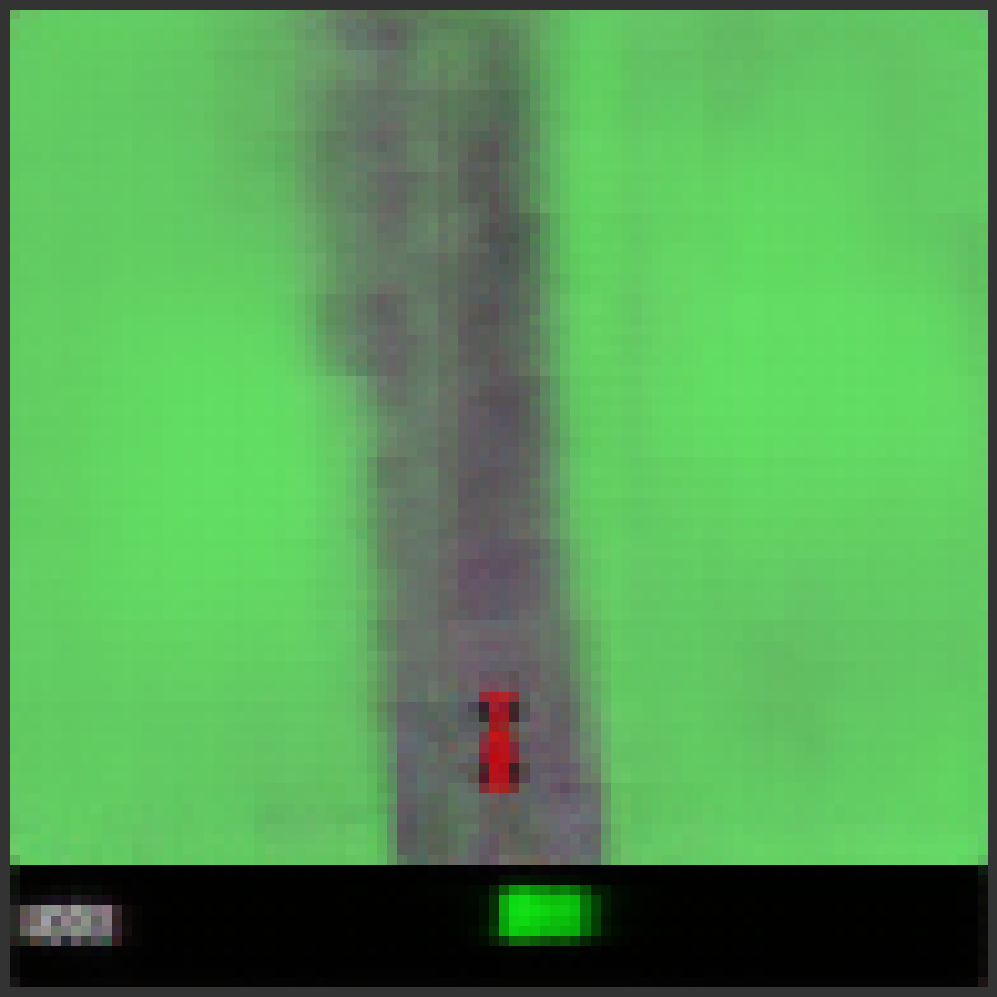

In [9]:
import tkinter as tk
from tkinter import ttk
from PIL import Image, ImageTk
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
from matplotlib.figure import Figure

# Initialize your Dreamer model and device here
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Load the start image
start_image = np.array(Image.open("startImage2.png"))  # Replace with uploaded image path
start_image_tensor = torch.from_numpy(np.transpose(start_image, (2, 0, 1))).unsqueeze(0).to(device).float() / 255.0

# Initialize the rollout
recurrent_state, latent_state = dreamer.rolloutInitialize(start_image_tensor)

# Define dark mode colors
BG_COLOR = "#333333"
FG_COLOR = "#DDDDDD"
SLIDER_COLOR = "#555555"
SLIDER_THUMB_COLOR = "#AAAAAA"
BUTTON_COLOR = "#444444"
BUTTON_HOVER_COLOR = "#666666"

# GUI setup
root = tk.Tk()
root.title("Dreamer Rollout Interface")
root.configure(bg=BG_COLOR)
root.attributes('-fullscreen', True)  # Fullscreen mode
root.bind("<Escape>", lambda event: root.attributes("-fullscreen", False))  # Exit fullscreen with ESC

# Position window on primary monitor (top left corner)
root.geometry(f"{root.winfo_screenwidth()}x{root.winfo_screenheight()}+0+0")

# Styling configuration
style = ttk.Style()
style.theme_use('clam')
style.configure("TFrame", background=BG_COLOR)
style.configure("TLabel", background=BG_COLOR, foreground=FG_COLOR)
style.configure("TButton", background=BUTTON_COLOR, foreground=FG_COLOR, font=("Arial", 12), relief="flat", padding=8)
style.map("TButton", background=[("active", BUTTON_HOVER_COLOR)])

# Display for rollout images
fig, ax = plt.subplots(figsize=(7, 7))
fig.patch.set_facecolor(BG_COLOR)
ax.set_facecolor(BG_COLOR)
canvas = FigureCanvasTkAgg(fig, master=root)
canvas.get_tk_widget().pack(side=tk.TOP, fill=tk.BOTH, expand=True, pady=(20, 10))

def update_observation_image(obs_image):
    ax.clear()
    ax.imshow(obs_image)
    ax.axis('off')
    canvas.draw()

# Frame for sliders positioned to the right and centered below the image
slider_frame = ttk.Frame(root)
slider_frame.pack(side=tk.TOP, pady=10)

action_labels = ["Steer", "Acceleration", "Brake"]
action_ranges = [(-1, 1), (0, 1), (0, 1)]
action = torch.tensor([0.0, 1.0, 0.0], dtype=torch.float32, device=device)
sliders = []

# Spacer to push sliders to the right
spacer = ttk.Frame(slider_frame, width=200, style="TFrame")
spacer.pack(side=tk.LEFT)

# Action sliders with custom ranges and names
for i in range(3):
    label = ttk.Label(slider_frame, text=action_labels[i], font=("Arial", 12, "bold"))
    label.pack(side=tk.LEFT, padx=(20, 10))

    slider = tk.Scale(slider_frame, from_=action_ranges[i][0], to=action_ranges[i][1], resolution=0.01, orient=tk.HORIZONTAL,
                      length=300, bg=BG_COLOR, fg=FG_COLOR, troughcolor=SLIDER_COLOR, sliderrelief="flat",
                      highlightthickness=0, activebackground=SLIDER_THUMB_COLOR)
    slider.set(action[i].item())
    slider.pack(side=tk.LEFT, padx=(0, 20))
    sliders.append(slider)

# Step function
def step():
    global recurrent_state, latent_state, action
    action_values = [slider.get() for slider in sliders]
    action = torch.tensor(action_values, dtype=torch.float32, device=device)
    
    # Rollout step
    next_recurrent_state, next_latent_state, next_observation, next_reward = dreamer.rolloutStep(
        recurrent_state, latent_state, action
    )
    recurrent_state, latent_state = next_recurrent_state, next_latent_state

    # Convert observation to image and display
    obs_image = next_observation.squeeze().permute(1, 2, 0).cpu().numpy()
    obs_image = np.clip(obs_image * 255, 0, 255).astype(np.uint8)
    update_observation_image(obs_image)

# Close (X) button in the top right corner
close_button = ttk.Button(root, text="X", command=root.destroy, style="TButton")
close_button.place(relx=0.98, rely=0.02, anchor="ne")  # Position in top-right corner

# Step button below sliders
step_button = ttk.Button(root, text="Step", command=step, style="TButton")
step_button.pack(side=tk.TOP, pady=20)

# Initial display
update_observation_image(start_image)

# Run GUI
root.mainloop()


In [ ]:
original = np.transpose(selectedEpisodeObservations.cpu()[1:], (0, 2, 3, 1))
reconstructed = np.transpose((dreamer.reconstructObservations(selectedEpisodeObservations, selectedEpisodeActions).cpu()), (0, 2, 3, 1))
i = 50
displayImage(np.concatenate((original[i], reconstructed[i]), 1))

In [ ]:
displayImage(np.transpose(selectedEpisodeObservations.cpu()[0], (1, 2, 0)))
saveImage(np.transpose((selectedEpisodeObservations[0].cpu().numpy()*255).astype(np.uint8), (1, 2, 0)), "startImage2.png")

In [ ]:
from PIL import Image
import numpy as np
startImage = np.array(Image.open("startImage.png"))
recurrentState, latentState = dreamer.rolloutInitialize(torch.from_numpy(np.transpose(startImage, (2, 0, 1))).unsqueeze(0).to(device).float()/255.0)
nextRecurrentState, nextLatentState, nextObservation, nextReward = dreamer.rolloutStep(recurrentState, latentState, torch.tensor([0, 1, 0], dtype=torch.float32, device=device))